In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# INARCH type modèles

Creer des bouts de code pour le calcul de modèles type INARCH:


On s'interesse à des modèles de forme :

$$ x_{i,t} ~ Poisson(l_{i,t})) $$
$$ l_{i,t} = s(t) * f_{\theta}(\frac{x_{i,t-1}}{s(t)}) $$

$f_{\theta}$ choisi dans un ensemble de 
 
Et on cherche les valeurs de 

## I Génération de Données

In [2]:
M = 8
T = 100
al =0.8
bet =10
f_init = lambda x: al *x +bet
f_init_vect = np.vectorize(f_init)

In [3]:


x_list= list()
X_cur =  np.random.randint(1,10,M)
for i in range(T):
    x_list.append(X_cur.copy())
    X_cur = np.random.poisson(f_init_vect(X_cur), M)

data_mat = np.concatenate(x_list).reshape(T,M)

## II Définition des fonctions du modèle

In [182]:
from math import log

class INREG_model():
    
    def __init__(self):
        self.f = None
        self.parameters = None
    
    def log_likelihood(self,data):
        """
        @param : data is a TxM matrices containing the data of differents series
        """
        
        T,M = data.shape
        
        def aux(x,l):
            if l != 0:
                return l - x * log(l)
            else:
                return x
        vect_aux = np.vectorize(aux)
        current_log_likelihood = 0
        for t in range(0,T-1):
            X_t,X_t1 = data[t,:], data[t+1,:]
            lambda_t =  self.f(X_t) 
            current_log_likelihood += sum(vect_aux(X_t1, lambda_t))
        return current_log_likelihood
    
    def pred(self,data):
        T,M = data.shape
        return np.concatenate([self.f(data[t,:]) for t in range(T)]).reshape(T,M)

    def fit(self, mat, **kwargs):
        def aux(params):
            self.parameters = params 
            return self.log_likelihood(mat)
        res = minimize(aux, self.parameters, bounds =self.bound, **kwargs)

        self.parameters = res.x
        
    
class INAR(INREG_model):
    def __init__(self):
        self.parameters = np.array([1,0])
        self.bound = ((1e-10,10.0),(0.,100))
        self.f =  lambda x: self.parameters[0]*x + self.parameters[1] 
        
       

In [11]:
model =  INAR()
model.fit(data_mat, options ={'disp' : True})

In [12]:
model.parameters

array([0.81022398, 9.56211718])

In [13]:
pred = model.pred(data_mat[:-1,:])

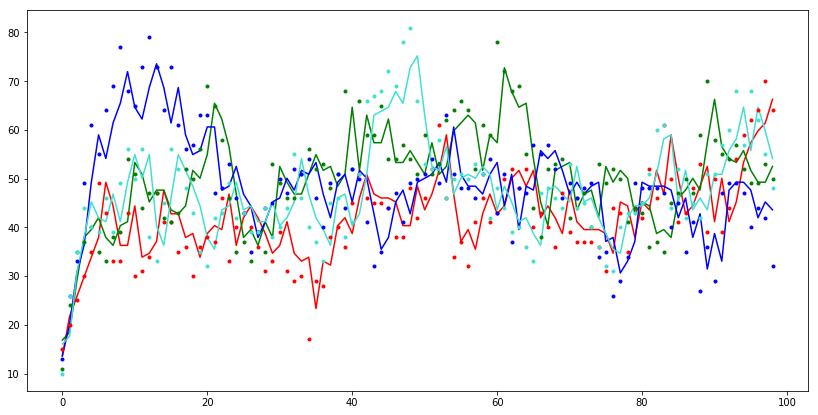

In [14]:
plt.figure(figsize=(14, 7))
plt.gca().set_prop_cycle('color', ['red', 'green', 'blue', 'turquoise'])
plt.plot(pred[:,:4])
plt.plot(data_mat[1:,:4],'.')
plt.show()

## III Concurrent models

### III.1 Génération

In [15]:
from math import exp, log

season_t =100

In [237]:
M = 8
T = 100
al = 0.1
bet = 1
f_init = lambda x: al *x +bet
f_init_vect = np.vectorize(f_init)

In [238]:
weight = np.random.exponential(0.5, size = M)
weight

array([0.11777058, 0.54282626, 0.21973111, 2.932009  , 0.20071062,
       0.01176204, 0.30451512, 0.03777796])

In [239]:
mask = np.zeros((M,T))
for i in range(M):
    a = int(np.random.exponential(8))
    b = int(np.random.exponential(80))
    print(a,b)
    mask[i,a:a+b] = 1


0 34
31 18
9 212
0 19
8 50
8 215
5 201
1 37


In [240]:

x_list= list()
X_cur =  np.random.randint(1,10,M)
for i in range(T):
    x_list.append(X_cur.copy())
    Xsum =  f_init_vect( X_cur/season_t).dot( mask[:,i] * weight) 
    X_cur = mask[:,i] *  np.random.poisson(season_t * f_init_vect(X_cur/season_t) * weight/Xsum, M)

data_mat = np.concatenate(x_list).reshape(T,M)

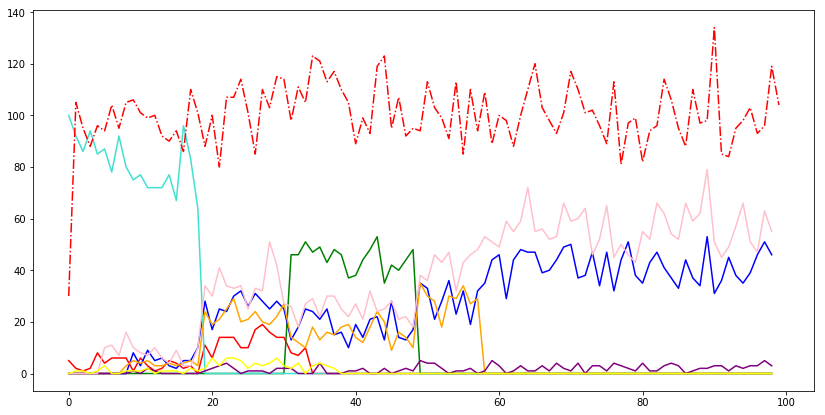

In [241]:
plt.figure(figsize=(14, 7))
plt.gca().set_prop_cycle('color', ['red', 'green', 'blue', 'turquoise','orange', 'purple', 'pink','yellow'])
plt.plot(data_mat[1:,:])
plt.plot(data_mat.sum(axis=1), '-.')
plt.show()

In [242]:
class  Concurrent_INREG(INREG_model):
    def __init__(self, weight = 1,season = 100 ):
        self.weight = weight
        self.season = season
        self.g =  None

        def aux( X):
            gX = self.g(X/ self.season)
            weighted_sum = gX.dot(self.weight) 
            return  self.season * self.weight * gX /weighted_sum
        self.f =  aux
        
class Concurrent_INAR(Concurrent_INREG):
    """ INAR(1) model"""

    def __init__(self, **kwargs):
        Concurrent_INREG.__init__(self, **kwargs)
        self.parameters = np.array([1,0])
        self.bound = ((1e-10, 100), (1e-10, 100))
        self.g = lambda x: self.parameters[0] * x + self.parameters[1]
        
class Concurrent_log_INAR(Concurrent_INREG):
    """ INAR(1) model"""

    def __init__(self, **kwargs):
        Concurrent_INREG.__init__(self, **kwargs)
        self.parameters = np.array([1, 0])
        self.bound = ((1e-10, 1000), (0., 100))
        self.g = lambda x: self.parameters[0] * np.log(1 + x) + self.parameters[1]

In [243]:
model = Concurrent_INAR(weight = weight)
model.fit(data_mat, options ={'disp' : True})
pred = model.pred(data_mat[:-1,:])

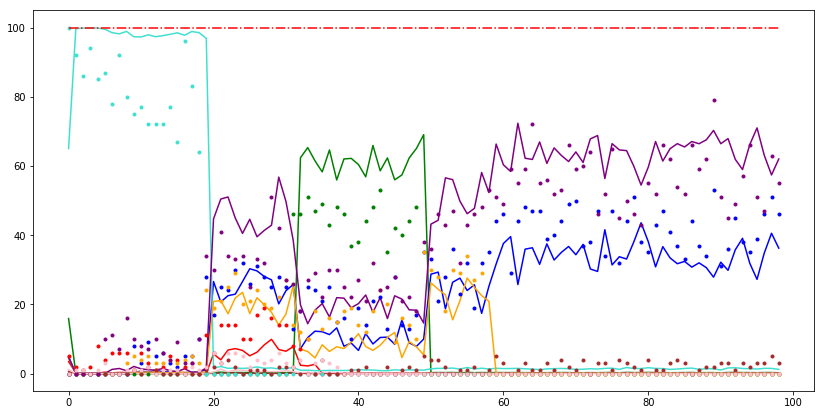

In [244]:
plt.figure(figsize=(14, 7))
plt.gca().set_prop_cycle('color', ['red', 'green', 'blue', 'turquoise','orange', 'brown','purple', 'pink'])
plt.plot(pred[:,:])
plt.plot(data_mat[1:,:],'.')
plt.plot(pred.sum(axis=1), '-.')
plt.show()

In [246]:
model.parameters

array([0.99999845, 0.00125564])